# Introduction

The goal of this project is to use natural language processing methods combined with a recurrent neural network to classify tweets as either relating to a disaster or not. A classifier such as this could have many possible applications. For instance it could act as an early warning system that a natural disaster has occurred, as people would likely be putting out tweets about a disaster before any news outlet could make a proper report. It could also be used as a method of active crisis monitoring. By isolating disaster related tweets, authorities could have a real time flow of information about the disaster without having to manually search for relevant tweets (Which could use a variety of hashtags).

This project is based on this Kaggle competition: https://www.kaggle.com/competitions/nlp-getting-started/, which provides the training and test data. The metric that the test data is evaluated against is the binary F1 score, which will be used to compare all of the created models against each other. 

# Imports

In [1]:
import os
import shutil
import json
import urllib.request
from zipfile import ZipFile

import string

import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SimpleRNN, Dropout
from tensorflow.keras import backend as K

from keras.utils.layer_utils import count_params

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kenneth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Load in Data

To start with, both the train and test data are loaded into their own individual data frames. 

In [2]:
train_file = "./nlp-getting-started/train.csv"
test_file = "./nlp-getting-started/test.csv"

train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)
print(train_df.shape)
train_df.head()

(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


The data contains five columns:
* id
* keyword
* location
* text
* target

As the goal of this project is to use natural language processing to predict the target, the `keyword` and `location` columns will be disregarded and the only column used for prediction will be `text`.

# Data Cleaning and Exploratory Data Analysis

This is a binary classification problem, therefore the `target` column only takes on two values. 0 means that a tweet does not relate to a disaster and 1 means that a tweet does relate to a disaster. It is important to visualize what proportion of the training set is labeled as 0 and what proportion is labeled as 1 in order to determine if there is any significant data imbalance.

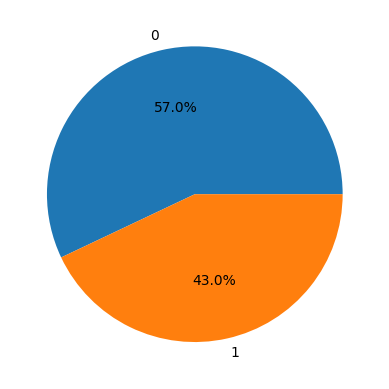

In [3]:
unique_labels, counts = np.unique(train_df.target.values, return_counts=True)
plt.pie(counts/np.sum(counts), labels=unique_labels, autopct='%1.1f%%')
plt.show()

43% of the tweets in the training data relate to disasters while the remaining 57% don't. The data is slightly imbalanced toward tweets that are not about disasters but the imbalance is not large enough to necessitate any data balancing techniques. 

Next, a small sample of tweets from the training data along with their label will be printed in order to get an idea of what preprocessing steps are necessary to prepare the text for classification. 

In [4]:
np.random.seed(42)
sample_idxs = np.random.randint(0, train_df.shape[0], 30)
for i in sample_idxs:
    print(f"({train_df.iloc[i]['target']}) {train_df.iloc[i]['text']}")

(1) I moved to England five years ago today. What a whirlwind of time it has been! http://t.co/eaSlGeA1B7
(1) Officials say a quarantine is in place at an Alabama home over a possible Ebola case after developing symptoms... http://t.co/rqKK15uhEY
(0) Omron HEM-712C Automatic Blood Pressure Monitor STANDARD AND LARGE BP CUFFS http://t.co/gJBAInQWN9 http://t.co/jPhgpL1c5x
(0) just had a panic attack bc I don't have enough money for all the drugs and alcohol I wanted to buy this year let alone my fall bills
(0) @Eganator2000 There aren't many Obliteration servers but I always like to play when there are :D
(0) This the same dude that obliterated meek mill. Dont judge a book by its cover. http://t.co/BabMf0W2YW
(0) Fire waves and darkness
(0) I would like to electrocute everyone who uses the word 'fair' in connection with income tax policies. - William F. Buckley Jr.
(1) VIDEO: 'We're picking up bodies from water': Rescuers are searching for hundreds of migrants in the Mediterranean after 

Some observations:
* Many tweets contain image links that will need to be removed
* Some tweets contain new line indicators that need to be replaced ("\n")
* Some tweets contain user handles that will need to be removed
* There is lots of varied punctuation that will need to be removed
* There are many numbers that probably won't give information about the tweet being a disaster or not
* There are many double or triple spaces that will need to be cleaned up
* Some tweets contain words that are not in English

A cleaning function will be defined that will convert the tweet into a list of words, applying data cleaning based on the observations made above. Additionally, any stop words will also be removed. A stop word is a common word like "and", "from", "it", or "with" to name a few. These words are grammatically necessary but won't be useful for disaster classification due to how common they are so they need to be removed. 

In [5]:
def make_clean_words_list(tweet_string):
    """Takes in the raw text of a tweet and returns a cleaned list of words"""
    
    # Make all text in the string lowercase
    tweet_string = tweet_string.lower()
    
    tweet_string = tweet_string.replace("\n", " ")
    
    # Remove all user handles (strings containing @) and urls (strings containing "http")
    word_list1 = [word for word in tweet_string.split(" ") if "@" not in word and "http" not in word]
    
    # Remove all punctuation
    translation = str.maketrans('', '', string.punctuation + "£")
    word_list2 = [word.translate(translation) for word in word_list1]
    
    # Remove all words with two or less characters, any words containing numbers, and any stopword.
    word_list3 = []
    for word in word_list2:
        if len(word) >= 3 and not any(char.isdigit() for char in word) and word not in stopwords.words('english'):
            word_list3.append(word)
            
    # Remove any leftover spaces in each word
    word_list4 = [word.replace(" ", "") for word in word_list3]
    
    return word_list4

Now the same sample set of tweets will be put through this `make_clean_words_list()` function to get a cleaned set of words for each tweet to be used for classification.

In [6]:
for i in sample_idxs:
    print(f"({train_df.iloc[i]['target']}) {make_clean_words_list(train_df.iloc[i]['text'])}")

(1) ['moved', 'england', 'five', 'years', 'ago', 'today', 'whirlwind', 'time']
(1) ['officials', 'say', 'quarantine', 'place', 'alabama', 'home', 'possible', 'ebola', 'case', 'developing', 'symptoms']
(0) ['omron', 'automatic', 'blood', 'pressure', 'monitor', 'standard', 'large', 'cuffs']
(0) ['panic', 'attack', 'dont', 'enough', 'money', 'drugs', 'alcohol', 'wanted', 'buy', 'year', 'let', 'alone', 'fall', 'bills']
(0) ['arent', 'many', 'obliteration', 'servers', 'always', 'like', 'play']
(0) ['dude', 'obliterated', 'meek', 'mill', 'dont', 'judge', 'book', 'cover']
(0) ['fire', 'waves', 'darkness']
(0) ['would', 'like', 'electrocute', 'everyone', 'uses', 'word', 'fair', 'connection', 'income', 'tax', 'policies', 'william', 'buckley']
(1) ['video', 'picking', 'bodies', 'water', 'rescuers', 'searching', 'hundreds', 'migrants', 'mediterranean', 'boat', 'carryi']
(1) ['kesabaran', 'membuahkan', 'hasil', 'indah', 'pada', 'saat', 'tepat', 'life', 'isnt', 'waiting', 'storm', 'pass', 'learning

These word lists look pretty good at a glance. Most of the extra, unneeded words have been removed so that each word list mostly contains only words that could reasonably be used for classification. There are still some hold out words that are unlikely to be useful such as the Indonesian words in the 10th sample or the word "raì¼l". These will be taken care of in a future step.

Now the cleaned word lists can be added to the train data frame as a new column.

In [7]:
train_df["word_list"] = [make_clean_words_list(train_df.iloc[i]['text']) for i in range(train_df.shape[0])]

As one more cleaning step any word that contains the new line "\n" indicator will be removed. 

In [8]:
for i in range(train_df.shape[0]):
    word_list = train_df.iloc[i].word_list
    for word in word_list:
        if r"/n" in word:
            print(word_list)
            break

In [9]:
train_df.head()

,id,keyword,location,text,target,word_list
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[deeds, reason, earthquake, may, allah, forgive]"
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[residents, asked, shelter, place, notified, o..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[people, receive, wildfires, evacuation, order..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[got, sent, photo, ruby, alaska, smoke, wildfi..."


It is possible that the cleaning has removed all words from some tweets, these will be disregarded and removed from the training data.

In [10]:
has_words = np.where([bool(x) for x in train_df.word_list])[0]
train_df = train_df.filter(has_words, axis=0)

Now the same data cleaning needs to be applied to the test data.

In [11]:
test_df["word_list"] = [make_clean_words_list(test_df.iloc[i]['text']) for i in range(test_df.shape[0])]

In [12]:
test_df.head()

,id,keyword,location,text,word_list
0,0,NaN,NaN,Just happened a terrible car crash,"[happened, terrible, car, crash]"
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...","[heard, earthquake, different, cities, stay, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...","[forest, fire, spot, pond, geese, fleeing, acr..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,"[apocalypse, lighting, spokane, wildfires]"
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,"[typhoon, soudelor, kills, china, taiwan]"


Next, two summary statistics of the training data's cleaned word list are calculated:
* `word_count`: The number of words in the cleaned word list
* `avg_word_len`: The mean length of words in the cleaned word list

In [13]:
train_df["word_count"] = [len(word_list) for word_list in train_df["word_list"]]
train_df["avg_word_len"] = [np.mean([len(word) for word in word_list]) if len(word_list) != 0 else np.nan for word_list in train_df["word_list"]]
train_df.head()

,id,keyword,location,text,target,word_list,word_count,avg_word_len
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[deeds, reason, earthquake, may, allah, forgive]",6,6.000000
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, ronge, sask, canada]",6,4.833333
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[residents, asked, shelter, place, notified, o...",11,7.090909
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[people, receive, wildfires, evacuation, order...",6,8.000000
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[got, sent, photo, ruby, alaska, smoke, wildfi...",9,5.222222


If there is a significant difference in the distribution of these two summary statistics then they may be useful features for classification. Two histograms comparing the distribution of each statistic are shown below.

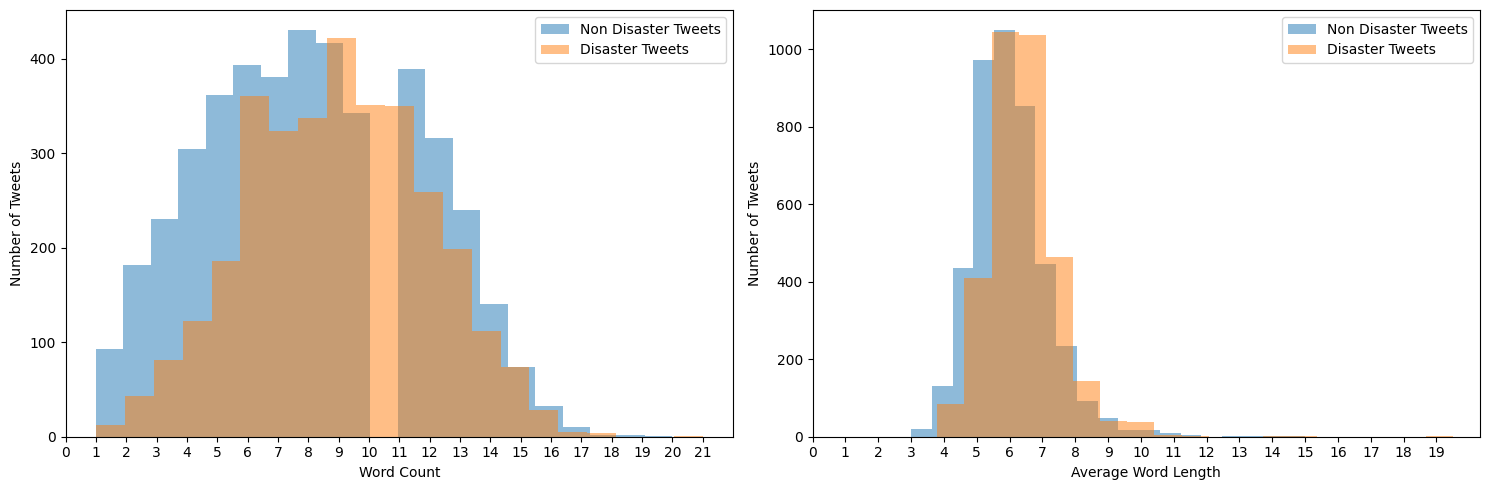

Disaster Tweets Mean Word Count: 8.029947016816402
Non Disaster Tweets Mean Word Count: 8.880428134556574

Disaster Tweets Mean Average Word Length: 6.010401172197597
Non Disaster Tweets Mean Average Word Length: 6.424605611329167


In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot for word_count
ax[0].hist(train_df.word_count[train_df.target == 0], bins=np.max(train_df.word_count), alpha=0.5, label="Non Disaster Tweets")
ax[0].hist(train_df.word_count[train_df.target == 1], bins=np.max(train_df.word_count), alpha=0.5, label="Disaster Tweets")
ax[0].set_xticks(range(0, np.max(train_df.word_count)+1, 1))
ax[0].set_xlabel('Word Count')
ax[0].set_ylabel('Number of Tweets')
ax[0].legend()

# Plot for avg_word_len
ax[1].hist(train_df.avg_word_len[train_df.target == 0], bins=int(np.max(train_df.avg_word_len)), alpha=0.5, label="Non Disaster Tweets")
ax[1].hist(train_df.avg_word_len[train_df.target == 1], bins=int(np.max(train_df.avg_word_len)), alpha=0.5, label="Disaster Tweets")
ax[1].set_xticks(range(0, int(np.max(train_df.avg_word_len))+1, 1))
ax[1].set_xlabel('Average Word Length')
ax[1].set_ylabel('Number of Tweets')
ax[1].legend()

plt.tight_layout()
plt.show()

print(f"Disaster Tweets Mean Word Count: {train_df.word_count[train_df.target == 0].mean()}")
print(f"Non Disaster Tweets Mean Word Count: {train_df.word_count[train_df.target == 1].mean()}")
print()
print(f"Disaster Tweets Mean Average Word Length: {train_df.avg_word_len[train_df.target == 0].mean()}")
print(f"Non Disaster Tweets Mean Average Word Length: {train_df.avg_word_len[train_df.target == 1].mean()}")

It appears that tweets about disasters and tweets not about disasters have approximately the same distribution in both summary statistics. Non disaster tweets on average have a higher value of `word_count` and a lower value of `avg_word_len`, but there is so much overlap in the distribution that these are unlikely to be useful features for classification so they will not be used going forward.

# Embedding

The lists of words that have been made for each tweet are not by themselves useful for machine learning as machine learning algorithms do not understand text based data. Therefore it is necessary to transform each word in these word lists from a string to a vector representation. This is done using an embedding, which provides a mapping from specific word strings to numerical vectors, allowing machine learning algorithms such as the Recurrant Neural Networks that will be used below to be able to work with the data.

For this project, the embedding that is going to be used is a pre-trained GloVe (Global Vectors for Word Representation) embedding. This embedding was developed by NLP researchers at Stanford University and offers several useful features. Firstly, each word in the large corpus of data it was trained on is uniquely represented by a real valued, 50 dimensional vector (Note versions with higher dimensional word representations such as 100d and 200d exist, but the 50d version was chosen for this project). Secondly, words that share similar meanings or appear in similar contexts are trained to appear closer together in the high dimensional vector space of the embedding. 

This close proximity of similar words in the vector space is the most important feature of GloVe and is the primary reason it was chosen for this project. When a machine learning model encounters these vectors, it can infer semantic similarities and differences. Synonyms may end up having vector representations that are close together, meaning that even if the author of two similar tweets used different choices of words, the representation of those words may still be very close to each other in the embedding vector space. 

Citation:
Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation. 

To start, the pre-trained GloVe embedding from Stanford's website is downloaded.

In [15]:
# urllib.request.urlretrieve(r"http://nlp.stanford.edu/data/glove.6B.zip", "Glove_embeddings.zip")
# with ZipFile("Glove_embeddings.zip") as z:
#     z.extractall("Glove_embeddings")

Next, the text file that Stanford provides needs to be parsed into a more useful form. Here each word embedding will be stored in a dictionary and be able to be accessed by using the word it represents as a key. 

In [16]:
embeddings_dict = {}
with open(r"Glove_embeddings\glove.6B.50d.txt", encoding="utf8") as embeddings_file:
    for line in embeddings_file:
        line_list = line.split()
        word = line_list[0]
        embedding_array = np.array(line_list[1:], dtype=float)
        embeddings_dict[word] = embedding_array

To demonstrate how similar words are near each other in the vector space, a function will be defined that takes in a word and outputs the ten closest words to it in the embedding vector space. 

In [17]:
def get_similar_words(word, embeddings_dict):
    keys = []
    mean_diffs = []
    for key in embeddings_dict.keys():
        if key != word:
            keys.append(key)
            mean_diffs.append(np.linalg.norm(embeddings_dict[key] - embeddings_dict[word]))

    i_sort = np.argsort(mean_diffs)
    return np.array(keys, dtype=object)[i_sort[:10]]

Below are some examples of disaster related words and the ten most similar words to them in the embedding vector space.

In [18]:
get_similar_words("disaster", embeddings_dict)

array(['disasters', 'catastrophe', 'catastrophic', 'tragedy', 'spill',
       'calamity', 'devastating', 'aftermath', 'devastation', 'flood'],
      dtype=object)

In [19]:
get_similar_words("earthquake", embeddings_dict)

array(['quake', 'temblor', 'tsunami', 'tremor', 'disaster', 'magnitude',
       'epicenter', 'earthquakes', 'jolted', 'devastating'], dtype=object)

In [20]:
get_similar_words("wildfire", embeddings_dict)

array(['wildfires', 'blaze', 'blazes', 'raging', 'fires', 'blizzard',
       'engulfed', 'torrent', 'firestorms', 'scorched'], dtype=object)

In [21]:
get_similar_words("emergency", embeddings_dict)

array(['relief', 'evacuation', 'aid', 'assistance', 'alert', 'temporary',
       'monitoring', 'requested', 'requiring', 'warning'], dtype=object)

# Make Train, Validation, and Test Arrays

Next, the arrays that will be used for training, validation, and testing will be made. The below function takes in a tweet's clean word list and uses the GloVe embedding dictionary defined above to covert it into a matrix of shape (n_words, 50). Because this matrix needs to be the same shape for every tweet, n_words will be set to the maximum `word_list` length in the training data. If a word list has fewer words than that maximum, the remaining rows will be padded with all zero vectors. If a word does not appear in the embedding dictionary, it is excluded. This helps to weed out some more of the less common words that made it through the data cleaning process. 

In [22]:
def vectorize_word_list(word_list, embeddings_dict, max_len):
    res = np.zeros((max_len, 50))
    i = 0
    for word in reversed(word_list):
        try:
            word_vector = embeddings_dict[word]
            res[i] = word_vector
            i += 1
        except KeyError:
            pass
        
    return np.flip(res, axis=0)

Next, the train and test arrays are created using the above function, containing the vectorized version of all tweets in their respective datasets.

In [23]:
max_len = np.max(train_df["word_count"])

X_train_full = np.empty((len(train_df), max_len, 50))
for i in range(len(train_df)):
    X_train_full[i] = vectorize_word_list(train_df.iloc[i].word_list, embeddings_dict, max_len)
y_train_full = train_df.target.values

X_test = np.empty((len(test_df), max_len, 50))
for i in range(len(test_df)):
    X_test[i] = vectorize_word_list(test_df.iloc[i].word_list, embeddings_dict, max_len)

In [24]:
X_train_full.shape

(7611, 21, 50)

An 80-20 train-validation split is performed in order to get a set of validation data in addition to the test data

In [25]:
X_train, X_validate, y_train, y_validate = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [26]:
print(X_train.shape, y_train.shape)
print(X_test.shape)


(6088, 21, 50) (6088,)
(3263, 21, 50)


# ModelTrainer Class

Next, in order to speed up iteration on the model and reduce repeated code, the `ModelTrainer` class will be defined that contains methods for fitting and evaluating models. The methods in the class are:
* `fit()`: Trains the model given the given training and validation data for a given number of epochs and with a given batch size. The final model as well as the training history is saved to file so it can be easily loaded in later without re-training the model, which happens if `load_from_file` is True. If `show_results` is true the results of the training are shown. 
* `plot_history()`: Creates three plots that plot the train and validation loss, accuracy, and F1 score over the training epochs.
* `print_best_model()`: Prints a summary of the best performing model, defined as the model with the lowest validation loss. 
* `make_test_output()`: Runs the model on test data and outputs the results in the necessary format to submit it to Kaggle.

Two callbacks will be used for model training:
* `ModelCheckpoint()`: This outputs the best model to file during training
* `EarlyStopping()`: This stops training if the validation loss does not improve for five epochs, helping to prevent over fitting

In [27]:
class ModelTrainer():
    def __init__(self, model, folder_path):
        self.model = model
        self.folder_path = folder_path
        self.history = None
        
    def fit(self, X_train, y_train, X_validate, y_validate, epochs=100, batch_size=32, load_from_file=False, show_results=True):
        # Define model filepaths
        model_file = os.path.join(self.folder_path, "model.ckpt")
        history_file = os.path.join(self.folder_path, "history.json")
        
        if load_from_file:
            # Load existing model from file
            self.model.load_weights(model_file)
            with open(history_file) as f:
                self.history = json.load(f)
                
        else:
            # Make output directory if it doesn't exist and delete everything in it
            os.makedirs(self.folder_path, exist_ok=True)
            shutil.rmtree(self.folder_path)

            # Define callbacks
            model_checkpoint = ModelCheckpoint(model_file, monitor="val_loss", save_weights_only=True, save_best_only=True, verbose=0)
            early_stopping = EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=5, verbose=0)

            # Train model
            self.history = self.model.fit(X_train, y_train, validation_data=[X_validate, y_validate], epochs=epochs, batch_size=batch_size,
                                    callbacks=[model_checkpoint, early_stopping], verbose=0).history

            # Write trained model history to file
            with open(history_file, "w+") as f:
                json.dump(self.history, f)
              
        if show_results:
            self.plot_history()
            self.print_best_model()
            

    def plot_history(self):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        epochs = list(range(1, len(self.history["loss"])+1))

        # Plotting Loss
        axes[0].plot(epochs, self.history["loss"], label='Training Loss')
        axes[0].plot(epochs, self.history["val_loss"], label='Validation Loss')
        axes[0].set_title('Loss')
        axes[0].set_xlabel('Epochs')
        axes[0].set_ylabel('Loss')
        axes[0].legend()

        # Plotting Accuracy
        axes[1].plot(epochs, self.history["accuracy"], label='Training Accuracy')
        axes[1].plot(epochs, self.history["val_accuracy"], label='Validation Accuracy')
        axes[1].set_title('Accuracy')
        axes[1].set_xlabel('Epochs')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend()

        # Plotting custom_f1_score
        axes[2].plot(epochs, self.history["custom_f1_score"], label='Training F1 Score')
        axes[2].plot(epochs, self.history["val_custom_f1_score"], label='Validation F1 Score')
        axes[2].set_title('F1 Score')
        axes[2].set_xlabel('Epochs')
        axes[2].set_ylabel('F1 Score')
        axes[2].legend()

        plt.tight_layout()
        plt.show()

        
    def print_best_model(self):
        best_idx = np.argmin(self.history["val_loss"])
        print(f"Best Epoch: {best_idx + 1}")
        print(f"Best Validation Loss: {self.history['val_loss'][best_idx]}")
        print(f"Best Accuracy: {self.history['accuracy'][best_idx]}")
        print(f"Best F1 Score: {self.history['val_custom_f1_score'][best_idx]}")
            
    def make_test_output(self, X_test, test_ids):
        out_file = os.path.join(self.folder_path, "submission.csv")
        yhat = np.round(self.model.predict(X_test)).astype(int)
        
        out_df = pd.DataFrame()
        out_df["id"] = test_ids
        out_df["target"] = yhat

        out_df.to_csv(out_file, index=False)

Also an implementation of the F1 score to be used as a metric for evaluation of models needs to be defined. This implementation was sourced from: https://saturncloud.io/blog/custom-f1score-metric-in-tensorflow/

In [28]:
def custom_f1_score(y_true, y_pred):
    # Define the true positives, false positives and false negatives
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    fp = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    # Calculate the precision and recall
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    # Calculate the F1 score
    f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    return f1_score

# First Simple Model

The first model will be a basic model with a single Recurrent Neural Network (RNN) layer that has 8 units followed by a dense layer to create the binary output using the sigmoid activation function. Binary Crossentropy will bey used for the loss function and ADAM will be used for the optimizer. The metrics of loss, accuracy, and F1 score will be tracked for each epoch.

Note: Each subsequent model will have the same loss function, optimizer and evaluation metrics.

In [29]:
model = Sequential()
model.add(SimpleRNN(8))
model.add(Dense(1, activation="sigmoid"))
model.build(input_shape=(None, max_len, 50))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', custom_f1_score])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 472       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


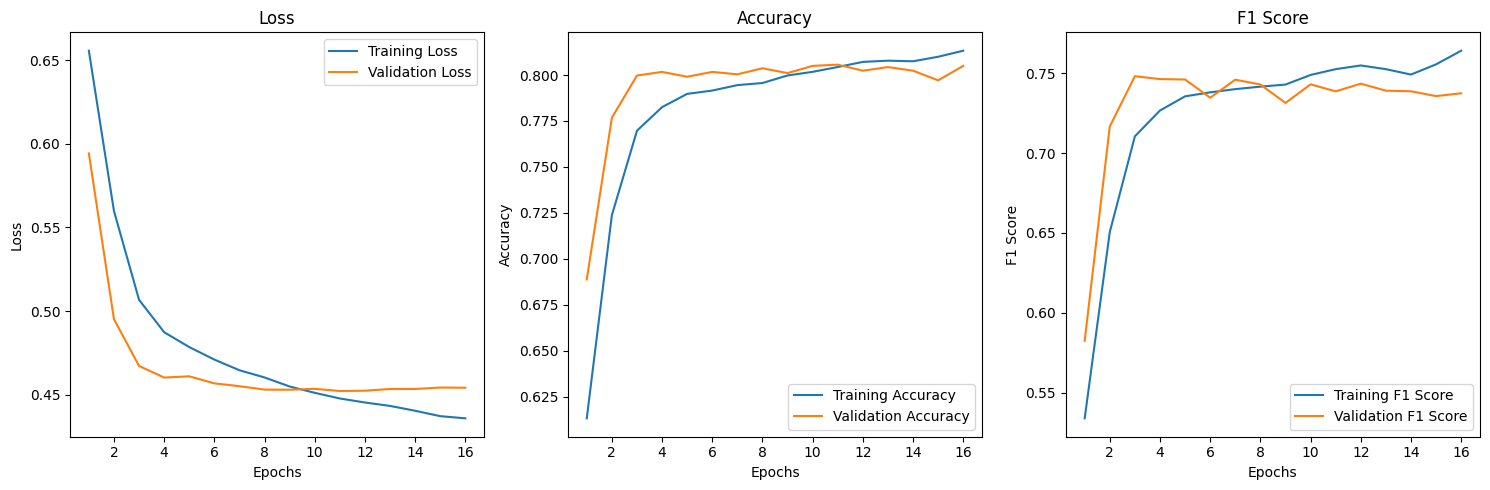

Best Epoch: 11
Best Validation Loss: 0.45211878418922424
Best Accuracy: 0.8043692708015442
Best F1 Score: 0.7386115193367004


In [30]:
model_trainer_1 = ModelTrainer(model, "./model1")
model_trainer_1.fit(X_train, y_train, X_validate, y_validate, load_from_file=True)

In [31]:
model_trainer_1.make_test_output(X_test, test_df.id)

102/102 [==============================] - 1s 4ms/step


This optimization ran for 16 epochs, being ended by early stopping because the validation loss did not improve after epoch 11 which had a validation accuracy of 0.804 and a validation F1 score of 0.739. The train and validation loss started to diverge from each other at around epoch 11, meaning that this is when the model started to over fit.

The test data F1 score from Kaggle for this model is **0.79037**, which is notably a bit higher than the validation F1 score of the model. 

# Adjust Number of Units

The next model will be mostly identical to the first model except for the number of units in the RNN layer will be doubled from 8 to 16. 

In [32]:
model2 = Sequential()
model2.add(SimpleRNN(16))
model2.add(Dense(1, activation="sigmoid"))
model2.build(input_shape=(None, max_len, 50))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', custom_f1_score])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 16)                1072      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,089
Trainable params: 1,089
Non-trainable params: 0
_________________________________________________________________


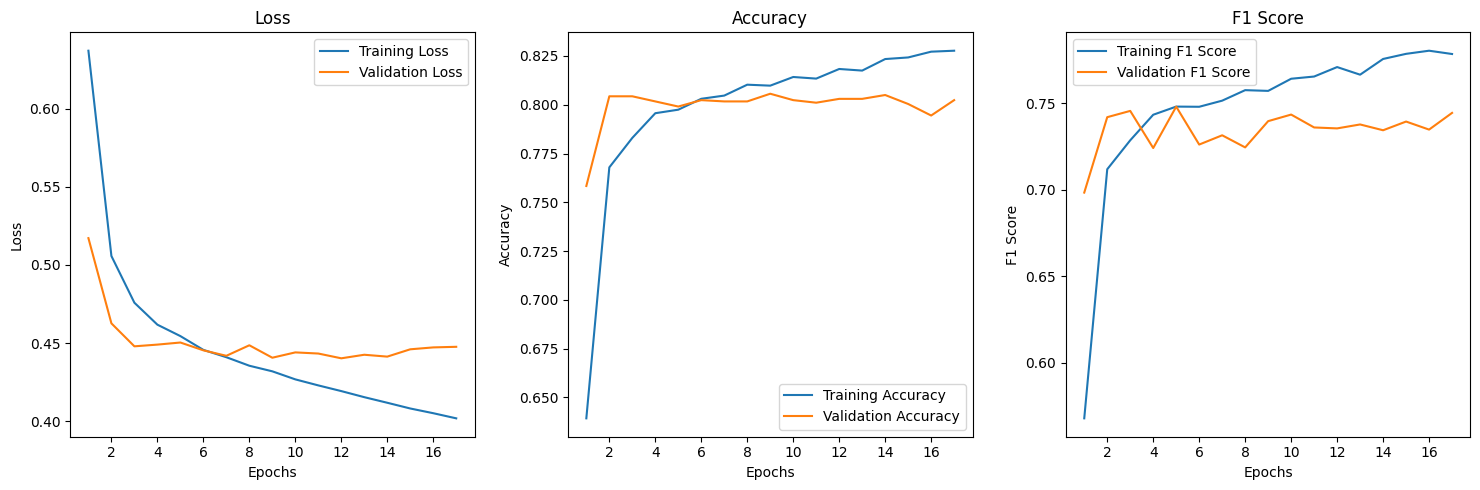

Best Epoch: 12
Best Validation Loss: 0.44021981954574585
Best Accuracy: 0.8183311223983765
Best F1 Score: 0.7355718016624451


In [33]:
model_trainer_2 = ModelTrainer(model2, "./model2")
model_trainer_2.fit(X_train, y_train, X_validate, y_validate, load_from_file=True)

In [34]:
model_trainer_2.make_test_output(X_test, test_df.id)

102/102 [==============================] - 1s 8ms/step


This optimization ran for 17 epochs, being ended by early stopping because the validation loss did not improve after epoch 12 which had a validation accuracy of 0.818 and a validation F1 score of 0.736. The train and validation loss started to diverge from each other at around epoch 6, meaning that this is when the model started to over fit.

The test data F1 score from Kaggle for this model is **0.79068**, which is notably a bit higher than the validation F1 score of the model. This is every so slightly higher than the test F1 score for the previous model.

Next, the opposite will be tried, halving the number of units in the RNN layer from 8 to 4.

In [35]:
model3 = Sequential()
model3.add(SimpleRNN(4))
model3.add(Dense(1, activation="sigmoid"))
model3.build(input_shape=(None, max_len, 50))

model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', custom_f1_score])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 4)                 220       
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________


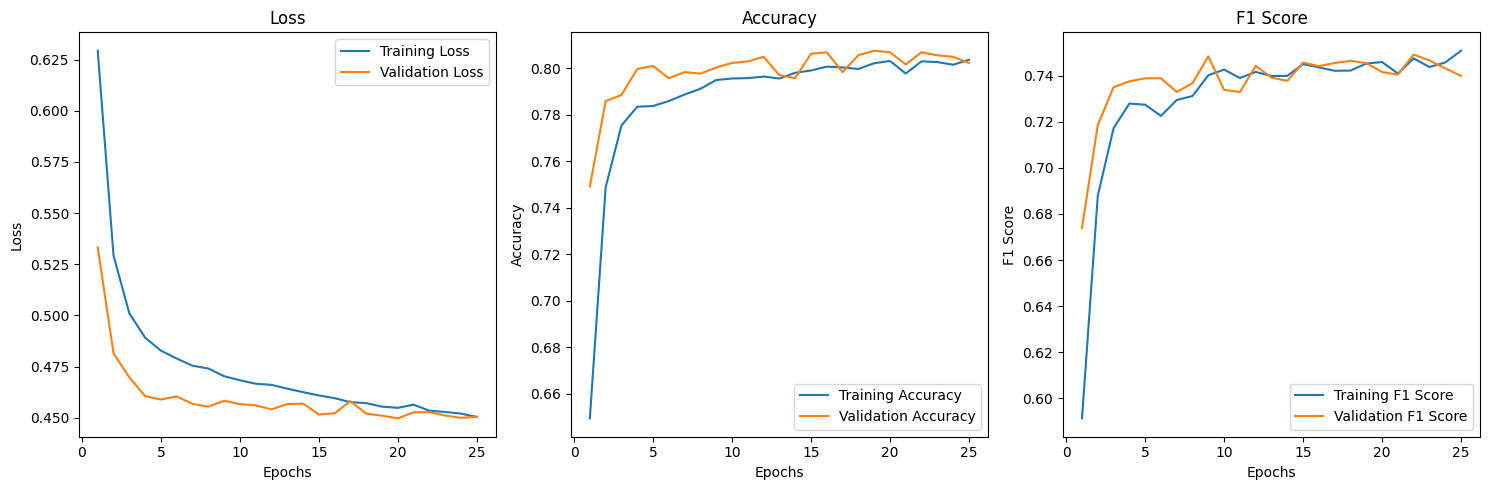

Best Epoch: 20
Best Validation Loss: 0.44972148537635803
Best Accuracy: 0.8032194375991821
Best F1 Score: 0.7414930462837219


In [36]:
model_trainer_3 = ModelTrainer(model3, "./model3")
model_trainer_3.fit(X_train, y_train, X_validate, y_validate, load_from_file=True)

In [37]:
model_trainer_3.make_test_output(X_test, test_df.id)

102/102 [==============================] - 1s 9ms/step


This optimization ran for 25 epochs, being ended by early stopping because the validation loss did not improve after epoch 20 which had a validation accuracy of 0.803 and a validation F1 score of 0.741. Unlike the previous models, this model is not showing signs of over fitting as the train and validation loss never diverge significantly.

The test data F1 score from Kaggle for this model is **0.78516**, which is notably a bit higher than the validation F1 score of the model. This is notably lower than the test F1 scores of the previous models, despite the training not showing signs of over fitting like the previous models did. 


# Add Dropout

In order to try to address the over fitting that is happening with 16 hidden units in the RNN layer, dropout regularization will be added which will make the optimizer randomly ignore 20% of all weights at every step, hopefully helping the model to generalize better.

In [38]:
model4 = Sequential()
model4.add(SimpleRNN(16))
model4.add(Dropout(0.2))
model4.add(Dense(1, activation="sigmoid"))
model4.build(input_shape=(None, max_len, 50))

model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', custom_f1_score])

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 16)                1072      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,089
Trainable params: 1,089
Non-trainable params: 0
_________________________________________________________________


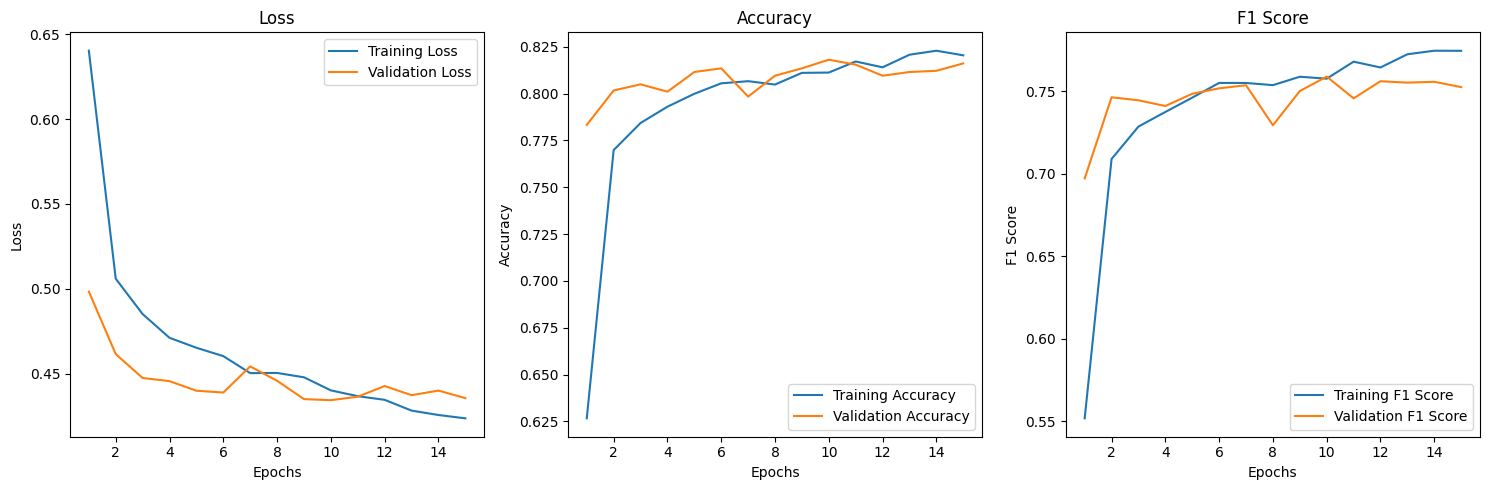

Best Epoch: 10
Best Validation Loss: 0.4343080222606659
Best Accuracy: 0.8112680912017822
Best F1 Score: 0.7589009404182434


In [39]:
model_trainer_4 = ModelTrainer(model4, "./model4")
model_trainer_4.fit(X_train, y_train, X_validate, y_validate, load_from_file=True)

In [40]:
model_trainer_4.make_test_output(X_test, test_df.id)

102/102 [==============================] - 1s 8ms/step


This optimization ran for 15 epochs, being ended by early stopping because the validation loss did not improve after epoch 10 which had a validation accuracy of 0.811 and a validation F1 score of 0.779. This model does still show some signs of overfitting starting around epoch 11 but it is not as severe as it was when there was no dropout.

The test data F1 score from Kaggle for this model is **0.79282**, which is notably a bit higher than the validation F1 score of the model, but not as much so as previous models. This test F1 score is the highest so far, but only by a little bit. 

# Make it Deeper

Oftentimes making a model deeper and adding more hidden layers helps it generalize better so next the amount of RNN layers will be adjusted. Two start with a single extra RNN layer will be added. Both RNN layers will have 16 hidden units and dropout will still be used.

In [41]:
model5 = Sequential()
model5.add(SimpleRNN(16, return_sequences=True))
model5.add(Dropout(0.2))
model5.add(SimpleRNN(16))
model5.add(Dropout(0.2))
model5.add(Dense(1, activation="sigmoid"))
model5.build(input_shape=(None, max_len, 50))

model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', custom_f1_score])

model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 21, 16)            1072      
                                                                 
 dropout_1 (Dropout)         (None, 21, 16)            0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 16)                528       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,617
Trainable params: 1,617
Non-trainable params: 0
_________________________________________________________________


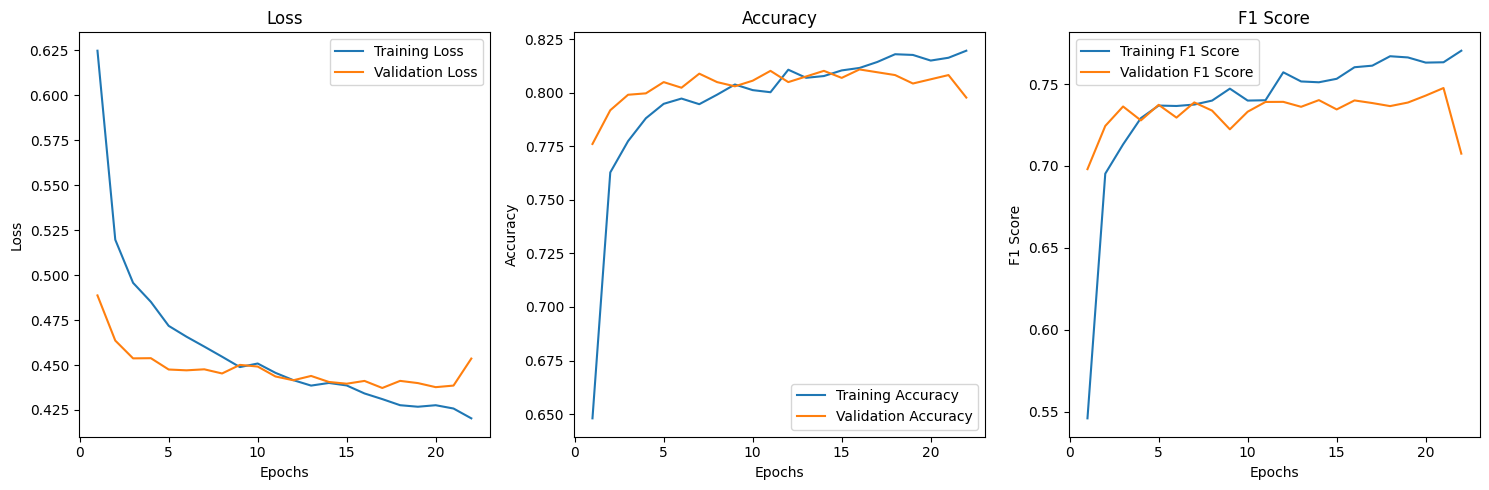

Best Epoch: 17
Best Validation Loss: 0.4372401237487793
Best Accuracy: 0.8143889904022217
Best F1 Score: 0.7384071946144104


In [42]:
model_trainer_5 = ModelTrainer(model5, "./model5")
model_trainer_5.fit(X_train, y_train, X_validate, y_validate, load_from_file=True)

In [43]:
model_trainer_5.make_test_output(X_test, test_df.id)

102/102 [==============================] - 2s 15ms/step


This optimization ran for 22 epochs, being ended by early stopping because the validation loss did not improve after epoch 17 which had a validation accuracy of 0.814 and a validation F1 score of 0.728. This model does still show some signs of overfitting starting around epoch 10.

The test data F1 score from Kaggle for this model is **0.79282**, which is notably a bit higher than the validation F1 score of the model. This is identical to the test accuracy from when there was only one hidden RNN layer.

Next, another additional RNN layer will be added.

In [44]:
model6 = Sequential()
model6.add(SimpleRNN(16, return_sequences=True))
model6.add(Dropout(0.2))
model6.add(SimpleRNN(16, return_sequences=True))
model6.add(Dropout(0.2))
model6.add(SimpleRNN(16))
model6.add(Dropout(0.2))
model6.add(Dense(1, activation="sigmoid"))
model6.build(input_shape=(None, max_len, 50))

model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', custom_f1_score])

model6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 21, 16)            1072      
                                                                 
 dropout_3 (Dropout)         (None, 21, 16)            0         
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 21, 16)            528       
                                                                 
 dropout_4 (Dropout)         (None, 21, 16)            0         
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 16)                528       
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

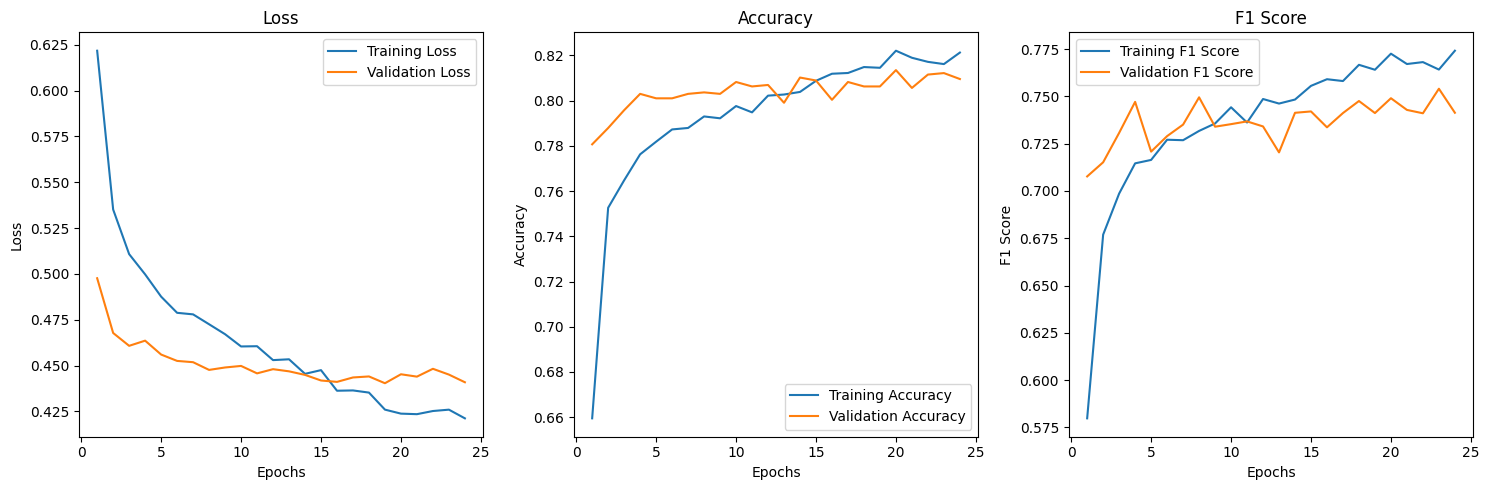

Best Epoch: 19
Best Validation Loss: 0.4403642416000366
Best Accuracy: 0.8145532011985779
Best F1 Score: 0.7411746382713318


In [45]:
model_trainer_6 = ModelTrainer(model6, "./model6")
model_trainer_6.fit(X_train, y_train, X_validate, y_validate, load_from_file=True)

In [46]:
model_trainer_6.make_test_output(X_test, test_df.id)

102/102 [==============================] - 2s 20ms/step


This optimization ran for 24 epochs, being ended by early stopping because the validation loss did not improve after epoch 19 which had a validation accuracy of 0.815 and a validation F1 score of 0.741. This model does still show some signs of overfitting starting around epoch 15.

The test data F1 score from Kaggle for this model is **0.79466**, which is notably a bit higher than the validation F1 score of the model. This is identical to the test accuracy from when there was only one hidden RNN layer. This is a little bit better than the previous best test F1 score of models so far.

# Grid Search

So far three hyperparameters have been shown to have some effect on the quality of the produced model. These are:
1. Number of hidden layers (or depth) of the model
2. Number of hidden units per hidden layer
3. Dropout proportion

In all tests so far, only one of these hyperparameters has been adjusted at a time. Next, in order to see if there is a set of these hyperparameters that produces better results, a grid search will be done over a range of these three hyperparameters. A model will be created and evaluated for every combination of hyperparameters in the search range. 

In [47]:
# Hyperparameter values for grid search
depths = [1, 2, 3, 4, 5]
hidden_units = [4, 8, 16, 32]
dropouts = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

In [48]:
def make_model(depth, hidden_units, dropout, max_len):
    """Function for making a tensorflow model with the passed in hyperparameters"""
    model = Sequential()
    for i in range(depth):
        if i != depth - 1:
            model.add(SimpleRNN(hidden_units, return_sequences=True))
        else:
            model.add(SimpleRNN(hidden_units))
            
        model.add(Dropout(dropout))
        
    model.add(Dense(1, activation="sigmoid"))
    model.build(input_shape=(None, max_len, 50))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', custom_f1_score])
    return model

The data frame `grid_search_df` will be used to store all of the hyperparameters and their corresponding models. 

In [49]:
grid_search_df = pd.DataFrame(columns=['Depth', 'Hidden Units', 'Dropout', 'N Params', 'Model Trainer'])

# Loop over all sets of hyperparameters
for depth in depths:
    for hidden_unit_num in hidden_units:
        for dropout in dropouts:
            model = make_model(depth, hidden_unit_num, dropout, max_len)
            n_params = count_params(model.trainable_weights)
            
            model_trainer = ModelTrainer(model, f"./grid_search_models/depth={depth}-hiddenUnits={hidden_unit_num}-dropout={dropout}")
            
            grid_search_df.loc[len(grid_search_df.index)] = [depth, hidden_unit_num, dropout, n_params, model_trainer]
            
grid_search_df.head()

,Depth,Hidden Units,Dropout,N Params,Model Trainer
0,1,4,0.0,225,<__main__.ModelTrainer object at 0x00000181931...
1,1,4,0.1,225,<__main__.ModelTrainer object at 0x0000018456B...
2,1,4,0.2,225,<__main__.ModelTrainer object at 0x0000018456A...
3,1,4,0.3,225,<__main__.ModelTrainer object at 0x0000018456A...
4,1,4,0.4,225,<__main__.ModelTrainer object at 0x0000018456B...


Now each model in the data frame will be trained

In [50]:
for i in range(len(grid_search_df)):
    grid_search_df.iloc[i]["Model Trainer"].fit(X_train, y_train, X_validate, y_validate, load_from_file=True, show_results=False)

Now every model in the grid search has been trained. Next, the validation loss, accuracy, and f1 score will be obtained from each model's history and put into the dataframe. 

In [51]:
val_losses = []
val_accuracies = []
val_f1s = []

for i in range(len(grid_search_df)):
    history = grid_search_df.iloc[i]["Model Trainer"].history
    
    i_best = np.argmin(history["val_loss"])
    
    val_losses.append(history["val_loss"][i_best])
    val_accuracies.append(history["val_accuracy"][i_best])
    val_f1s.append(history["val_custom_f1_score"][i_best])
    
grid_search_df["Validation Loss"] = val_losses
grid_search_df["Validation Accuracy"] = val_accuracies
grid_search_df["Validation F1 Score"] = val_f1s

grid_search_df.head()

,Depth,Hidden Units,Dropout,N Params,Model Trainer,Validation Loss,Validation Accuracy,Validation F1 Score
0,1,4,0.0,225,<__main__.ModelTrainer object at 0x00000181931...,0.451001,0.813526,0.755187
1,1,4,0.1,225,<__main__.ModelTrainer object at 0x0000018456B...,0.452489,0.808930,0.749180
2,1,4,0.2,225,<__main__.ModelTrainer object at 0x0000018456A...,0.463359,0.797768,0.738587
3,1,4,0.3,225,<__main__.ModelTrainer object at 0x0000018456A...,0.461868,0.807617,0.745032
4,1,4,0.4,225,<__main__.ModelTrainer object at 0x0000018456B...,0.461206,0.806303,0.744675


This data frame can now be used to get the model with the lowest validation loss to be the final result of the grid search.

In [52]:
best_loss_idx = np.argmin(grid_search_df["Validation Loss"])
grid_search_df.iloc[best_loss_idx]

Depth                                                                  3
Hidden Units                                                          16
Dropout                                                              0.1
N Params                                                            2145
Model Trainer          <__main__.ModelTrainer object at 0x00000181CCD...
Validation Loss                                                 0.428679
Validation Accuracy                                             0.815496
Validation F1 Score                                             0.756116
Name: 61, dtype: object

The best model from the grid search had a depth of 3, 16 hidden units per layer, and a dropout of 0.1.

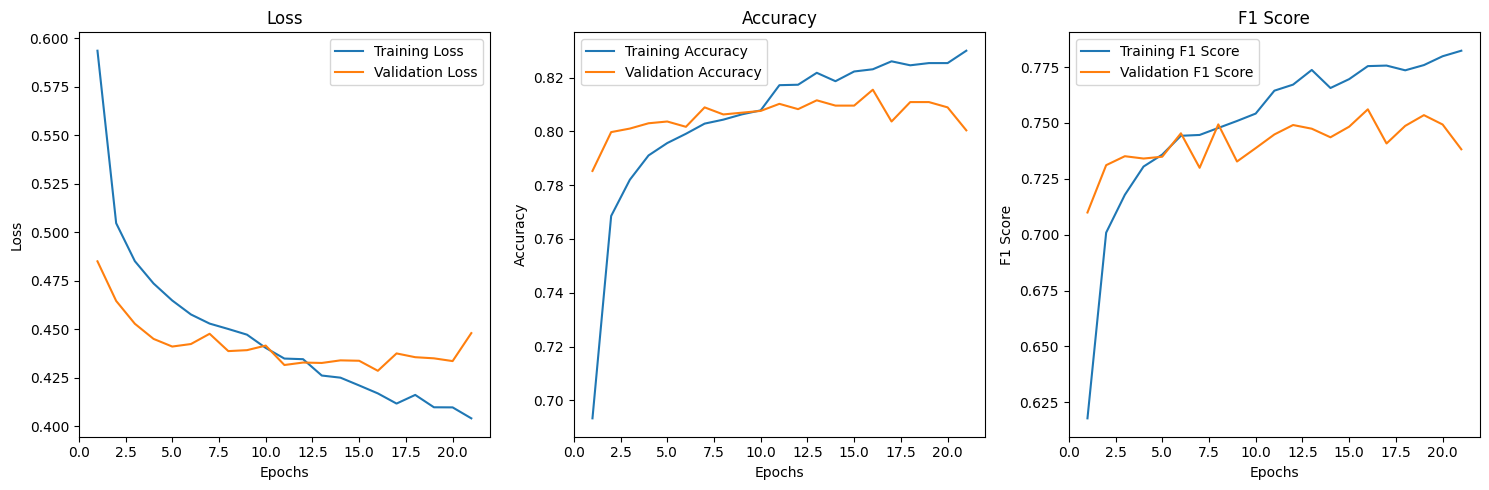

Best Epoch: 16
Best Validation Loss: 0.42867881059646606
Best Accuracy: 0.8230946063995361
Best F1 Score: 0.7561163306236267


In [53]:
grid_search_df.iloc[best_loss_idx]["Model Trainer"].plot_history()
grid_search_df.iloc[best_loss_idx]["Model Trainer"].print_best_model()

In [54]:
grid_search_df.iloc[best_loss_idx]["Model Trainer"].make_test_output(X_test, test_df.id)

102/102 [==============================] - 2s 20ms/step


The best model's optimization ran for 21 epochs, being ended by early stopping because the validation loss did not improve after epoch 16 which had a validation accuracy of 0.823 and a validation F1 score of 0.756. This model does still show some signs of overfitting starting around epoch 10. This is the best validation accuracy and f1 score of any model made, meaning that the grid search did find a better set of hyperparameters than previous models.

The test data F1 score from Kaggle for this model is **0.79129**, which is notably a bit higher than the validation F1 score of the model. This is identical to the test accuracy from when there was only one hidden RNN layer. This is notably not the best F1 score of any of the models trained, with the earlier model with a depth of 3, 16 hidden units per layer, and a dropout of 0.2 performed slightly better on the test data. Still, on the validation data, this grid search result performed the best.

# Results and Analysis

After individually tuning model parameters and then finally running a grid search to find the optimal combination of hyperparameters, the best model had 3 hidden RNN layers each with 16 units each and during training a dropout of 0.1 was used. This  final model had a loss of 0.429, an accuracy of 0.823, and an F1 score of 0.756 on the validation data. Below is a confusion matrix of this best performing model.

48/48 [==============================] - 1s 21ms/step


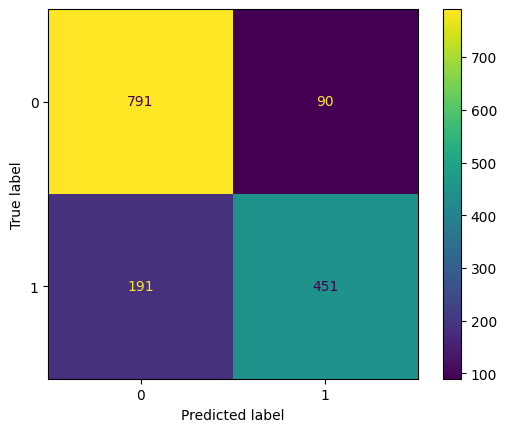

In [55]:
y_hat_best = np.round(grid_search_df.iloc[best_loss_idx]["Model Trainer"].model.predict(X_validate)).astype(int)

ConfusionMatrixDisplay.from_predictions(y_validate, y_hat_best)
plt.show()

Based on this confusion matrix, the best model had more than twice as many false negatives than it did false positives, although there were still a fair amount of false positives. This means that the best model is more likely to not label a tweet as being about a natural disaster when it really was than it is to label a tweet as a natural disaster when it really wasn't. 

It is also notable that even with the grid search, the results obtained are not that much better than the initial results on the first simple model. The first simple model had a validation F1 score of 0.739 which is not that much lower than the final model's F1 score of 0.756. This could mean that the hyperparameters that were chosen to tune, although they slightly effect model performance, don't effect model performance enough to greatly improve or worsen the performance of the model, at least within the bounds of the grid search performed.

Below a histogram is made of each metric across all models created in the grid search. 

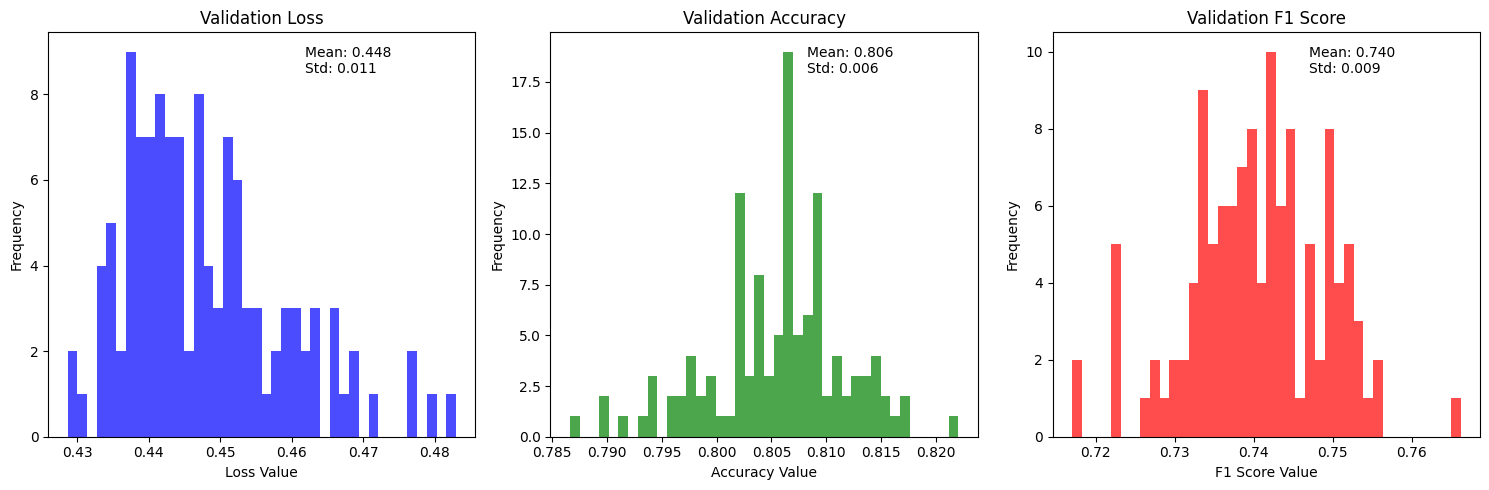

In [57]:
_, bins_loss = np.histogram(grid_search_df["Validation Loss"], bins=40)
_, bins_accuracy = np.histogram(grid_search_df["Validation Accuracy"], bins=40)
_, bins_f1 = np.histogram(grid_search_df["Validation F1 Score"], bins=40)

# Create a figure and a 1x3 grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Loss Plot
mean_loss = np.mean(grid_search_df["Validation Loss"])
std_loss = np.std(grid_search_df["Validation Loss"])
axs[0].hist(grid_search_df["Validation Loss"], bins=bins_loss, color='blue', alpha=0.7)
axs[0].set_title("Validation Loss")
axs[0].set_xlabel("Loss Value")
axs[0].set_ylabel("Frequency")
axs[0].text(0.6, 0.9, f'Mean: {mean_loss:.3f}\nStd: {std_loss:.3f}', transform=axs[0].transAxes)

# Accuracy Plot
mean_accuracy = np.mean(grid_search_df["Validation Accuracy"])
std_accuracy = np.std(grid_search_df["Validation Accuracy"])
axs[1].hist(grid_search_df["Validation Accuracy"], bins=bins_accuracy, color='green', alpha=0.7)
axs[1].set_title("Validation Accuracy")
axs[1].set_xlabel("Accuracy Value")
axs[1].set_ylabel("Frequency")
axs[1].text(0.6, 0.9, f'Mean: {mean_accuracy:.3f}\nStd: {std_accuracy:.3f}', transform=axs[1].transAxes)

# F1 Score Plot
mean_f1 = np.mean(grid_search_df["Validation F1 Score"])
std_f1 = np.std(grid_search_df["Validation F1 Score"])
axs[2].hist(grid_search_df["Validation F1 Score"], bins=bins_f1, color='red', alpha=0.7)
axs[2].set_title("Validation F1 Score")
axs[2].set_xlabel("F1 Score Value")
axs[2].set_ylabel("Frequency")
axs[2].text(0.6, 0.9, f'Mean: {mean_f1:.3f}\nStd: {std_f1:.3f}', transform=axs[2].transAxes)

plt.tight_layout()
plt.show()

It can be seen from these histograms that while there is some variation in each metric across the different set of hyperparameters tried, for each metric, the standard deviation of the distribution is quite low, meaning that the chosen hyperparameters did not have a great effect on the performance of the model.

# Conclusion

The purpose of this project was to classify tweets as either being related to a disaster or not by using natural language processing techniques combined with recurrent neural networks. The tweets were read in and cleaned, removing things such as URLs, user handles, punctuation, and special characters to get a cleaned list of important words in the tweet. A pre-trained GloVe embedding was then used to transform these word lists into numerical feature matrices that can be used to train machine learning algorithms. Various architectures of recurrent neural networks were fit to the training data in order to find a set of hyper parameters that produced the best model. The best model produced was able to achieve an F1 score of 0.79129 on the test set.

While the final model does perform decently well there are several avenues that could be explored in the future to make it perform even better such as:
* Trying out more advanced recurrent neural network architectures such as Long Short Term Memory (LSTM) or Gated Recurrent Unit (GRU)
* Experimenting with different embedding methods such as Word2Vec or TF-IDF or even training an embedding matrix along with the rest of the model to make an embedding custom made for this task.
* Experimented with more hyper parameters such as learning rate, activation function type, or optimizer. 
* Adding more dense layers after the RNN layers to possibly make a better classifier